# Lecture 5: Class demo

## Imports, Announcements, LOs

### Imports

In [1]:
# import the libraries
import os
import sys
sys.path.append(os.path.join(os.path.abspath("../"), "code"))
from plotting_functions import *
from utils import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

pd.set_option("display.max_colwidth", 200)

Do you recall [the restaurants survey](https://ubc.ca1.qualtrics.com/jfe/form/SV_73VuZiuwM1eDVrw) you completed at the start of the course?

Let's use that data for this demo. You'll find a [wrangled version](https://github.com/UBC-CS/cpsc330-2023W1/blob/main/lectures/data/cleaned_restaurant_data.csv) in the course repository.

In [2]:
df = pd.read_csv('../data/cleaned_restaurant_data.csv')

In [3]:
df.describe()

,eat_out_freq,age,n_people,price
count,964.000000,964.000000,6.960000e+02,696.000000
mean,2.585187,23.975104,1.439254e+04,1472.179152
std,2.246486,4.556716,3.790481e+05,37903.575636
min,0.000000,10.000000,-2.000000e+00,0.000000
25%,1.000000,21.000000,1.000000e+01,18.000000
50%,2.000000,22.000000,2.000000e+01,25.000000
75%,3.000000,26.000000,3.000000e+01,40.000000
max,15.000000,46.000000,1.000000e+07,1000000.000000


Are there any unusual values in this data that you notice?
Let's get rid of these outliers. 

In [4]:
upperbound_price = 200
lowerbound_people = 1
df = df[~(df['price'] > 200)]
restaurant_df = df[~(df['n_people'] < lowerbound_people)]
restaurant_df.shape

(942, 11)

In [5]:
restaurant_df.describe()

,eat_out_freq,age,n_people,price
count,942.000000,942.000000,674.000000,674.000000
mean,2.598057,23.992569,24.973294,34.023279
std,2.257787,4.582570,22.016660,29.018622
min,0.000000,10.000000,1.000000,0.000000
25%,1.000000,21.000000,10.000000,18.000000
50%,2.000000,22.000000,20.000000,25.000000
75%,3.000000,26.000000,30.000000,40.000000
max,15.000000,46.000000,200.000000,200.000000


### Data splitting 

We want to predict whether a restaurant is liked or disliked.

In [6]:
# Separate `X` and `y`. 

X = restaurant_df.drop(columns=['target'])
y = restaurant_df['target']

Below I'm perturbing this data just to demonstrate a few concepts. Don't do it in real life. 

In [7]:
X.at[459, 'food_type'] = 'Quebecois'
X['price'] = X['price'] * 100

In [8]:
# Split the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

<br><br>

### EDA 

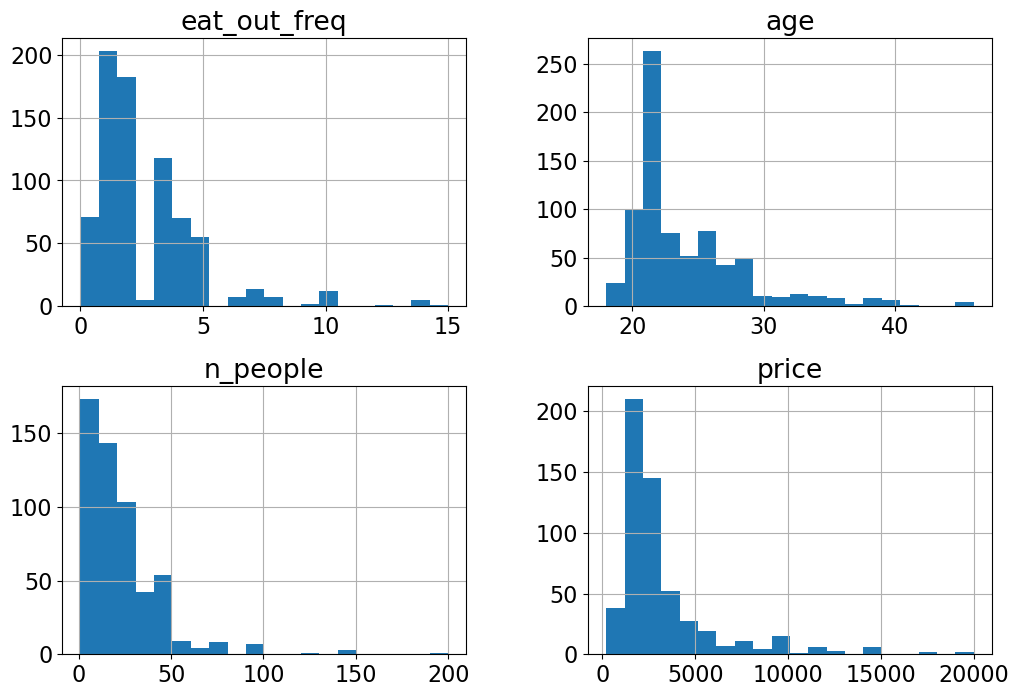

In [9]:
X_train.hist(bins=20, figsize=(12, 8));

Do you see anything interesting in these plots? 

In [10]:
X_train['food_type'].value_counts()

food_type
Other                189
Canadian/American    131
Chinese              102
Indian                36
Italian               32
Thai                  20
Fusion                18
Mexican               17
fusion                 3
Quebecois              1
Name: count, dtype: int64

Error in data collection? Probably "Fusion" and "fusion" categories should be combined?

In [11]:
X_train['food_type'] = X_train['food_type'].replace("fusion", "Fusion")
X_test['food_type'] = X_test['food_type'].replace("fusion", "Fusion")

In [12]:
X_train['food_type'].value_counts()

food_type
Other                189
Canadian/American    131
Chinese              102
Indian                36
Italian               32
Fusion                21
Thai                  20
Mexican               17
Quebecois              1
Name: count, dtype: int64

Again, usually we should spend lots of time in EDA, but let's stop here so that we have time to learn about transformers and pipelines.   

<br><br>

### Dummy Classifier

In [13]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier()
scores = cross_validate(dummy, X_train, y_train, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.000763,0.000494,0.516556,0.514950
1,0.000466,0.000336,0.516556,0.514950
2,0.000440,0.000326,0.516556,0.514950
3,0.000452,0.000320,0.513333,0.515755
4,0.000428,0.000323,0.513333,0.515755


We have a relatively balanced distribution of both 'like' and 'dislike' classes.

<br><br>

### Let's try KNN on this data

Do you think KNN would work directly on `X_train` and `y_train`?

In [14]:
# Preprocessing and pipeline
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
# knn.fit(X_train, y_train)

We need to preprocess the data before passing it to ML models. What are the different types of features in the data? 

In [15]:
X_train.head()

,north_america,eat_out_freq,age,n_people,price,food_type,noise_level,good_server,comments,restaurant_name
80,No,2.0,21,30.0,2200.0,Chinese,high,No,The environment was very not clean. The food tasted awful.,NaN
934,Yes,4.0,21,30.0,3000.0,Canadian/American,low,Yes,The building and the room gave a very comfy feeling. Immediately after sitting down it felt like we were right at home.,NaN
911,No,4.0,20,40.0,2500.0,Canadian/American,medium,Yes,I was hungry,Chambar
459,Yes,5.0,21,NaN,NaN,Quebecois,NaN,NaN,NaN,NaN
62,Yes,2.0,24,20.0,3000.0,Indian,high,Yes,bad taste,east is east


- What all transformations we need to apply before training a machine learning model? 
- Can we group features based on what type of transformations we would like to apply?

In [16]:
numeric_feats = [] # Continuous and quantitative features
categorical_feats = [] # Discrete and qualitative features
binary_feats = [] # Categorical features with only two possible values 
ordinal_feats = [] # Some natural ordering in the categories 
noise_cats = []
drop_feats = ['comments', 'restaurant_name'] # Let's drop them for now. 

<br><br>

Let's begin with numeric features. What if we just use numeric features to train a KNN model? Would it work? 

In [18]:
# knn.fit(X_train[numeric_feats], y_train)

We need to deal with NaN values. 

### sklearn's `SimpleImputer` 

In [42]:
# Impute numeric features using SimpleImputer

from sklearn.impute import SimpleImputer


In [43]:
# knn.fit(X_train_num_imp, y_train)

No more errors. It worked! Let's try cross validation. 

In [44]:
# cross_val_score(knn, X_train_num_imp, y_train).mean()

We have slightly improved results in comparison to the dummy model. 

### Discussion questions 

- What's the difference between sklearn estimators and transformers?  
- Can you think of a better way to impute missing values? 

<br><br><br><br>

Do we need to scale the data? 

In [22]:
X_train[numeric_feats]

,age,n_people,price
80,21,30.0,2200.0
934,21,30.0,3000.0
911,20,40.0,2500.0
459,21,NaN,NaN
62,24,20.0,3000.0
...,...,...,...
106,27,10.0,1500.0
333,24,12.0,800.0
393,20,5.0,1500.0
376,20,NaN,NaN


In [23]:
# Scale the imputed data 

from sklearn.preprocessing import StandardScaler


### What are some alternative methods for scaling?
- [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html): Transform each feature to a desired range
- [RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html): Scale features using median and quantiles. Robust to outliers. 
- [Normalizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html): Works on rows rather than columns. Normalize examples individually to unit norm.
- [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html): A scaler that scales each feature by its maximum absolute value.
    - What would happen when you apply `StandardScaler` to sparse data?    
- You can also apply custom scaling on columns using [`FunctionTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html). For example, when a column follows the power law distribution (a handful of your values have many data points whereas most other values have few data points) log scaling is helpful.    

- For now, let's focus on `StandardScaler`. Let's carry out cross-validation

In [24]:
# cross_val_score(knn, X_train_num_imp_scaled, y_train)

array([0.55629139, 0.49006623, 0.56953642, 0.54      , 0.53333333])

In this case, we don't see a big difference with `StandardScaler`. But usually, scaling is a good idea. 

- This worked but are we doing anything wrong here? 
- What's the problem with calling `cross_val_score` with preprocessed data? 
- How would you do it properly?
<br><br><br><br>

In [25]:
# Create a pipeline 


Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [45]:
# cross_val_score(pipe_knn, X_train[numeric_feats], y_train)

- What all things are happening under the hood? 
- Why is this a better approach? 

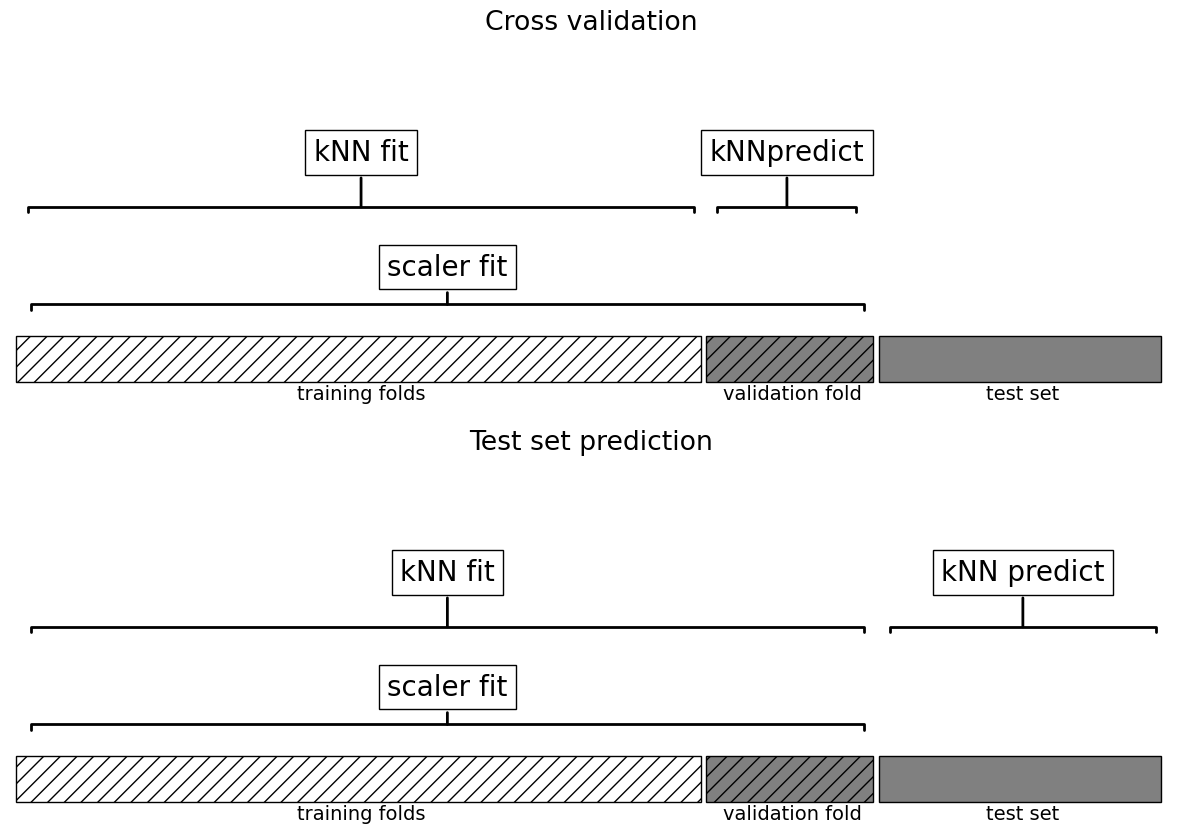

In [46]:
plot_improper_processing("kNN")

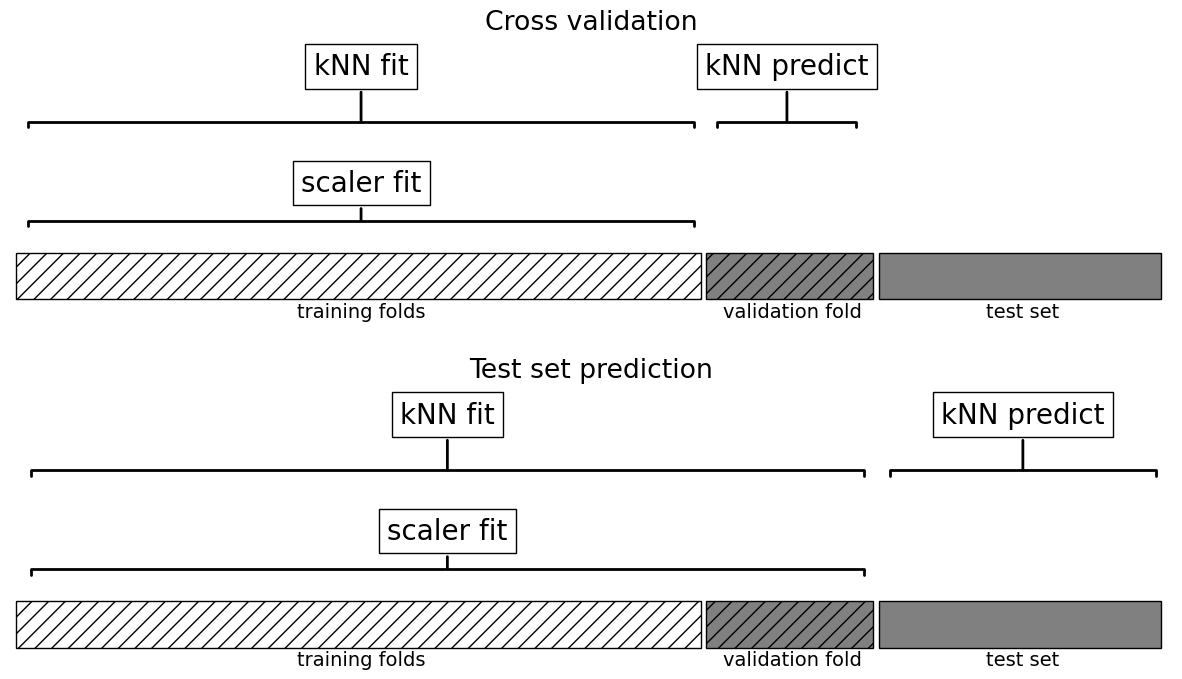

In [47]:
plot_proper_processing("kNN")

<br><br><br><br>

### Categorical features

Let's assess the scores using categorical features.

In [48]:
X_train[categorical_feats]

,north_america,food_type
80,No,Chinese
934,Yes,Canadian/American
911,No,Canadian/American
459,Yes,Quebecois
62,Yes,Indian
...,...,...
106,No,Chinese
333,No,Other
393,Yes,Canadian/American
376,Yes,NaN


In [49]:
X_train['north_america'].value_counts()

north_america
Yes                    415
No                     330
Don't want to share      8
Name: count, dtype: int64

In [50]:
X_train['food_type'].value_counts()

food_type
Other                189
Canadian/American    131
Chinese              102
Indian                36
Italian               32
Fusion                21
Thai                  20
Mexican               17
Quebecois              1
Name: count, dtype: int64

In [51]:
X_train_cat = X_train[categorical_feats]
X_test_cat = X_test[categorical_feats]

In [52]:
# One-hot encoding of categorical features 
from sklearn.preprocessing import OneHotEncoder


In [53]:
# X_train_ohe

In [54]:
# ohe_feats = ohe.get_feature_names_out().tolist()
# pd.DataFrame(X_train_ohe, columns = ohe_feats)

- It's a sparse matrix. 
- Why? What would happen if we pass `sparse=False`? Why we might want to do that? 

In [55]:
# cross_val_score(knn, X_train_ohe, y_train)

Are we breaking the golden rule here? Let's do this properly with a pipeline. 

In [56]:
# Code to create a pipeline for OHE and KNN


In [39]:
# cross_val_score(pipe_ohe_knn, X_train_cat, y_train)

- What's wrong here? 
- How can we fix this? 

In [57]:
# Fix the OHE

In [58]:
# cross_val_score(pipe_ohe_knn, X_train_cat, y_train)

Right now we are working with numeric and categorical features separately. But ideally when we create a model, we need to use all these features together. 

Enter column transformer! In the next lecture we'll discuss column transformer. 